In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Load data from the GitHub raw URL
url = "https://raw.githubusercontent.com/btenneson/public_projects/main/survey_lung_cancer_cleaned1.csv"
data = pd.read_csv(url)

# Load the CSV file from your local directory
# Replace 'your_file.csv' with the actual path to your CSV file
# data = pd.read_csv("G:\\My Drive\\research\\kaggle\\survey_lung_cancer_cleaned1.csv")


# Define the objective function to maximize the absolute correlation
def objective_function(bias, data):
    # Calculate synthetic scores
    synthetic_scores = data.iloc[:, 1:].dot(bias)
    
    # Correlation with the first column
    correlation = np.corrcoef(data.iloc[:, 0], synthetic_scores)[0, 1]
    
    # Minimize the negative absolute correlation
    return -abs(correlation)

# Initial guess for the bias vector (random values, no need to normalize)
n_minus_1 = data.shape[1] - 1  # Assuming data includes the first column
initial_bias = np.random.rand(n_minus_1)

# Minimization process
result = minimize(
    objective_function,
    initial_bias,
    args=(data,),
    method='Powell',
    options={'disp': True}
)

# Check results
if result.success:
    optimized_bias = result.x
    print("Optimized bias vector:", optimized_bias)
    print("Achieved correlation:", -result.fun)  # Negate to show maximized correlation
else:
    print("Optimization failed:", result.message)

Optimization terminated successfully.
         Current function value: -0.632739
         Iterations: 5
         Function evaluations: 763
Optimized bias vector: [0.00693605 0.0073129  0.40141836 0.69591238 0.43180968 0.49818248
 0.49607928 0.8363116  0.82182429 0.34814611 1.11581723 0.59145734
 0.2522848  0.53991169 0.1459259 ]
Achieved correlation: 0.6327388429389953


In [2]:
len(optimized_bias)

15

Best Threshold: 0.5700000000000001
Best Accuracy: 93.81%
Confusion Matrix:
 [[ 27  12]
 [  7 261]]
F1 Score: 0.9648798521256932
Precision: 0.9560439560439561
Recall: 0.9738805970149254
AUC: 0.9599598163031


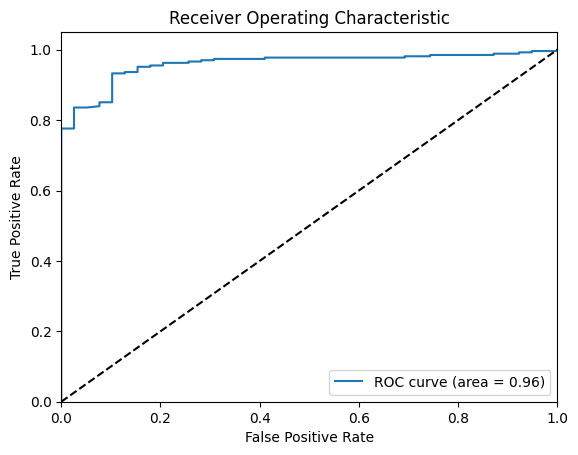

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and 'synthetic_scores' column is calculated
if 'synthetic_scores' not in data.columns:
    # Placeholder for your synthetic_scores calculation logic
    synthetic_scores = data.iloc[:, 1:].dot(optimized_bias)
    data['synthetic_scores'] = synthetic_scores

# Initialize the linear regression model
model = LinearRegression()

# The input X needs to be reshaped for fitting with sklearn (single feature)
X = data['synthetic_scores'].values.reshape(-1, 1)  # Predictor - synthetic scores
y = data.iloc[:, 0].values  # Response variable from the first column

# Fit the model
model.fit(X, y)

# Use the model to make predictions
fitted_scores = model.predict(X)

# Function to calculate accuracy for a given threshold
def calculate_accuracy(threshold):
    y_pred = (fitted_scores >= threshold).astype(int)
    return accuracy_score(y, y_pred)

# Test thresholds from 0.0 to 1.0 in small increments
thresholds = np.arange(0.0, 1.01, 0.01)
accuracies = [calculate_accuracy(t) for t in thresholds]

# Find the threshold with the highest accuracy
best_threshold_index = np.argmax(accuracies)
best_threshold = thresholds[best_threshold_index]
best_accuracy = accuracies[best_threshold_index]

# Generate predictions using the best threshold
best_predicted_labels = (fitted_scores >= best_threshold).astype(int)
data['Optimized_Predicted'] = best_predicted_labels

# Print results
print(f"Best Threshold: {best_threshold}")
print(f"Best Accuracy: {best_accuracy * 100:.2f}%")

# Additional metrics
conf_matrix = confusion_matrix(y, best_predicted_labels)
f1 = f1_score(y, best_predicted_labels)
precision = precision_score(y, best_predicted_labels)
recall = recall_score(y, best_predicted_labels)
auc = roc_auc_score(y, fitted_scores)

print("Confusion Matrix:\n", conf_matrix)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y, fitted_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()